In [159]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_squared_log_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import Ridge

In [111]:
train_data = pd.read_csv('../data/train.csv', delimiter=',').drop(['Id'], axis=1)

In [112]:
def split_target_numerical_and_categorical_columns(df, target_name):
    target_column = train_data[target_name]
    numerical_columns = train_data.drop(columns=[target_name]).select_dtypes(include=[np.number])
    categorical_columns = train_data.drop(columns=[target_name]).select_dtypes(exclude=[np.number])
    return target_column, numerical_columns, categorical_columns

In [113]:
def one_hot_encode_categorical_data(categorical_data):
    return pd.get_dummies(categorical_data)

In [114]:
def filter_columns_corr_more_than_x(x, df, target_series, target_name):
    df_and_target = pd.concat([df, train_data[target_name]], axis=1)
    df_and_target_corr = df_and_target.corr().abs().drop(columns=[target_name])
    return df.loc[:, (df_and_target_corr.loc[target_name,:]>=x)]

In [115]:
target_column, numerical_columns, categorical_columns = split_target_numerical_and_categorical_columns(train_data, 'SalePrice')
print(target_column.shape)
print(numerical_columns.shape)
print(categorical_columns.shape)

(1460,)
(1460, 36)
(1460, 43)


In [116]:
non_number_data_description = categorical_columns.describe()
non_number_data_description

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,...,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,...,870,605,1311,1326,1340,3,157,49,1267,1198


In [139]:
one_hot_categorical_columns = one_hot_encode_categorical_data(categorical_columns)
one_hot_categorical_columns.sum(axis=0).head()

MSZoning_C (all)      10.0
MSZoning_FV           65.0
MSZoning_RH           16.0
MSZoning_RL         1151.0
MSZoning_RM          218.0
dtype: float64

In [141]:
scaler_cat = MinMaxScaler()
scaled_cat_train_data = scaler_cat.fit_transform(one_hot_categorical_columns.fillna(0))
one_hot_categorical_columns = pd.DataFrame(scaled_cat_train_data, columns=one_hot_categorical_columns.columns)

scaler_num = MinMaxScaler()
scaled_num_train_data = scaler_num.fit_transform(numerical_columns.fillna(0))
numerical_columns = pd.DataFrame(scaled_num_train_data, columns=numerical_columns.columns)

In [149]:
train_cat_data = filter_columns_corr_more_than_x(0.1, one_hot_categorical_columns, train_data['SalePrice'], 'SalePrice')
num_cat_columns = train_cat_data.columns
print(train_cat_data.shape)
train_num_data = filter_columns_corr_more_than_x(0.1, numerical_columns, train_data['SalePrice'], 'SalePrice')
num_data_columns = train_num_data.columns
print(train_num_data.shape)
processed_train_data = pd.concat([train_cat_data, train_num_data], axis=1, ignore_index=True).fillna(0)
print(processed_train_data.shape)
print(type(processed_train_data))

(1460, 107)
(1460, 26)
(1460, 133)
<class 'pandas.core.frame.DataFrame'>


In [150]:
split_on_row = int(0.8*processed_train_data.shape[0])
X_train = processed_train_data.iloc[:split_on_row, :]
y_train = train_data.iloc[:split_on_row, :]['SalePrice']
X_validation = processed_train_data.iloc[split_on_row:, :]
y_validation = train_data.iloc[split_on_row:, :]['SalePrice']

## Train model

In [160]:
ridge_model = Ridge(alpha=0.1, fit_intercept=True, normalize=True)
ridge_model.fit(X_train, y_train)
ridge_prediction = ridge_model.predict(X_validation)
ridge_regression_r2 = r2_score(y_validation, ridge_prediction)
print(np.sqrt(mean_squared_log_error(y_validation, ridge_prediction, sample_weight=None, multioutput='uniform_average')))

0.15916546545831647


In [161]:
bag_model = BaggingRegressor()
bag_model.fit(X_train, y_train)
bag_prediction = bag_model.predict(X_validation)
bag_regression_r2 = r2_score(y_validation, bag_prediction)
print(np.sqrt(mean_squared_log_error(y_validation, bag_prediction, sample_weight=None, multioutput='uniform_average')))

0.15846397610992835


In [153]:
def run_knn(n_neighbors, X_train, y_train, X_validation, y_validation):
    score_on_train = {}
    score_on_validation = {}

    for i, weights in enumerate(['uniform', 'distance']):
        nn_model = KNeighborsRegressor(n_neighbors, weights = weights, p=1)
        nn_model.fit(X_train, y_train)
        train_prediction = nn_model.predict(X_train)
        score_on_train[weights] = r2_score(y_train, train_prediction)

        nn_prediction = nn_model.predict(X_validation)
        score_on_validation[weights] = np.sqrt(mean_squared_log_error(y_validation, nn_prediction, sample_weight=None, multioutput='uniform_average'))#r2_score(y_validation, nn_prediction)
    return score_on_validation, nn_prediction

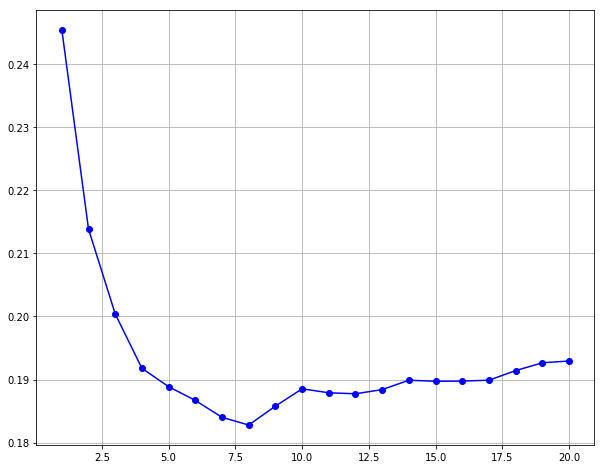

In [154]:
knn_r2 = pd.DataFrame(columns = ['no_of_neighbours', 'r2'])
for n_neighbors in range(1,21):
    score, prediction = run_knn(n_neighbors, X_train, y_train, X_validation, y_validation)
    result = pd.DataFrame([[n_neighbors, score['distance']]],
                    columns = ['no_of_neighbours', 'r2'])
    knn_r2 = knn_r2.append(result)

f, ax = plt.subplots(figsize=(10, 8))
ax.plot(knn_r2['no_of_neighbours'], knn_r2['r2'], '-bo')
ax.grid(True)

In [155]:
n_neighbors = 14
nn_regression_r2, nn_regression_prediction = run_knn(n_neighbors, X_train, y_train, X_validation, y_validation)
print(np.sqrt(mean_squared_log_error(y_validation, nn_regression_prediction, sample_weight=None, multioutput='uniform_average')))

0.1898955002470823
